Попробуйте обучить нейронную сеть LSTM на любом другом   датасете (любимый временной ряд, текст на русском (другом  языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний).  
*Опишите, какой результата вы получили? Что помогло вам улучшить ее точность?

*Попробуйте на numpy реализовать нейронную сеть архитектуры LSTM

In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
# Создаем объект для токенизапции
tokenizer = Tokenizer(    num_words=10000)
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/content/drive/MyDrive/learning/neural network/2/ПТЭ.txt').read()
#Читаем текст
data_text = data.lower().split(" ")


--2021-12-21 00:10:05--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.194.128, 173.194.197.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2021-12-21 00:10:05 (82.1 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



убираю пунктуацию

In [4]:
import string

In [5]:
for p in string.punctuation:
    if p in data:
        data = data.replace(p, '')

data

'Требования к рабочим местам работников перевозчика используемым работниками перевозчика техническим средствам и порядок их содержания определяются перевозчиком с учетом требований трудового законодательства Российской Федерации положений настоящих ПТЭ\nПеревозчик обязан обеспечить эксплуатацию работниками метрополитена объектов инфраструктуры метрополитена в соответствии с правилами и инструкциями по охране труда пожарной безопасности установленными для выполняемой работы и возможность немедленного извещения уполномоченного работника перевозчика о любой ситуации угрожающей жизни и здоровью людей или безопасности движения\nПраво управления подвижным составом сигналами аппаратами механизмами другими устройствами связанными с обеспечением безопасности движения и эксплуатации метрополитена а также перевода стрелки предоставляется перевозчиком уполномоченным на это работникам при исполнении ими своих служебных обязанностей\nПеревозчик не вправе предоставлять доступ в кабины управления к ус

In [6]:
corpus = data.lower().split("\n")

In [7]:
corpus

['требования к рабочим местам работников перевозчика используемым работниками перевозчика техническим средствам и порядок их содержания определяются перевозчиком с учетом требований трудового законодательства российской федерации положений настоящих птэ',
 'перевозчик обязан обеспечить эксплуатацию работниками метрополитена объектов инфраструктуры метрополитена в соответствии с правилами и инструкциями по охране труда пожарной безопасности установленными для выполняемой работы и возможность немедленного извещения уполномоченного работника перевозчика о любой ситуации угрожающей жизни и здоровью людей или безопасности движения',
 'право управления подвижным составом сигналами аппаратами механизмами другими устройствами связанными с обеспечением безопасности движения и эксплуатации метрополитена а также перевода стрелки предоставляется перевозчиком уполномоченным на это работникам при исполнении ими своих служебных обязанностей',
 'перевозчик не вправе предоставлять доступ в кабины управ

Исполним токенизацию и кодирование

In [8]:
tokenizer.fit_on_texts( corpus)
total_words = len(tokenizer.word_index) + 1

# создание входных последовательностей с использованием списка токенов
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# последовательности прокладок
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# создание предикторов и меток
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]

label = ku.to_categorical(label, num_classes=total_words)

In [9]:
token_list

[111, 179, 74, 32, 535, 174, 43, 3834, 22, 13, 4, 81, 123, 400, 28]

In [10]:
tokenizer.index_word[10]

'пути'

In [11]:
tokenizer.word_index['светофор']

191

In [12]:
input_sequences[11:15,:]

array([[   0,    0,    0, ..., 1359,    2,  111],
       [   0,    0,    0, ...,    2,  111,   86],
       [   0,    0,    0, ...,  111,   86, 1026],
       [   0,    0,    0, ...,   86, 1026,  673]], dtype=int32)

In [13]:
label.shape

(21911, 3835)

In [14]:
callback = EarlyStopping(monitor='val_loss', patience=30) # создаем обратный вызов - calback - тут "Ранний останов"

In [15]:
total_words

3835

In [16]:
from tensorflow.python.keras.regularizers import L2
model = Sequential()
model.add(Embedding(total_words, 256, input_length=max_sequence_len-1))  # вложение тренируемое для перехода от слова к его векторному коду 
# на вход вложения (эмбединга) передаем вектор словарь (длина равна словарю, вектор разреженный)), на выход строим вектор из n (тут 256) координат - он плотный
# model.add(Bidirectional(LSTM(50, return_sequences = True)))

model.add(LSTM(512, return_sequences=False))
# model.add(LSTM(256))
# model.add(LSTM(128, return_sequences=True))
# model.add(LSTM(64))
model.add(Dropout( 0.2))
model.add(Dense(total_words, activation='tanh', kernel_regularizer= regularizers.L2(0.05)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 378, 256)          981760    
                                                                 
 lstm (LSTM)                 (None, 512)               1574912   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 3835)              1967355   
                                                                 
 dense_1 (Dense)             (None, 3835)              14711060  
                                                                 
Total params: 19,235,087
Trainable params: 19,235,087
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
history = model.fit(predictors, label, epochs=100, validation_split=0.33, callbacks=[callback],verbose=1)
# history = model.fit(predictors, label, epochs=50,verbose=1)

Epoch 1/100
459/459 [==============================] - 99s 202ms/step - loss: 8.2317 - accuracy: 0.0294 - val_loss: 7.2825 - val_accuracy: 0.0228
Epoch 2/100
459/459 [==============================] - 92s 200ms/step - loss: 6.6566 - accuracy: 0.0340 - val_loss: 7.4057 - val_accuracy: 0.0315
Epoch 3/100
459/459 [==============================] - 91s 199ms/step - loss: 6.3628 - accuracy: 0.0497 - val_loss: 7.4630 - val_accuracy: 0.0348
Epoch 4/100
459/459 [==============================] - 90s 197ms/step - loss: 6.0506 - accuracy: 0.0731 - val_loss: 7.5045 - val_accuracy: 0.0613
Epoch 5/100
459/459 [==============================] - 90s 196ms/step - loss: 5.7234 - accuracy: 0.1046 - val_loss: 7.6795 - val_accuracy: 0.0827
Epoch 6/100
459/459 [==============================] - 90s 196ms/step - loss: 5.3831 - accuracy: 0.1435 - val_loss: 7.8845 - val_accuracy: 0.0909
Epoch 7/100
459/459 [==============================] - 90s 197ms/step - loss: 5.0576 - accuracy: 0.1822 - val_loss: 7.9574 -

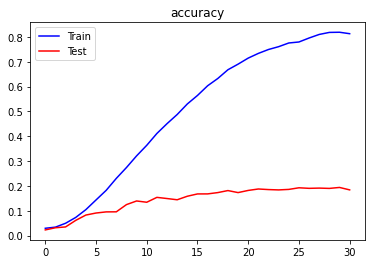

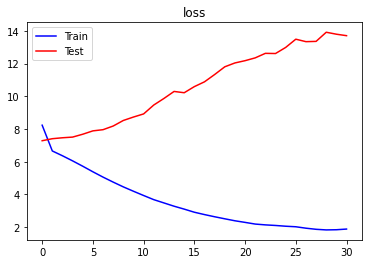

In [18]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Train')
plt.plot(epochs, acc_v, 'r', label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Train')
plt.plot(epochs, loss_v, 'r', label='Test')
plt.title('loss')
plt.legend()

plt.show()

In [19]:
seed_text = "машинист несёт ответственность"
seed_text = seed_text.lower()
#seed_text = "She is my girl, I see in"
next_words = 50
  
for _ in range(next_words):
  token_list = tokenizer.texts_to_sequences([seed_text])[0]
  # print(token_list)
  token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
  #predicted = model.predict_classes(token_list, verbose=0)
  output_word = ""
  y_p=model.predict(token_list)
  y_predict = y_p * np.random.random(  size = (1,y_p.shape[1]))
  predicted_ind = np.argmax(y_predict,axis = 1)
  for word, index in tokenizer.word_index.items():
    if index == predicted_ind:
      output_word = word
      break
  seed_text += " " + output_word
print(seed_text)

машинист несёт ответственность устанавливаемым светофоры подвагонного сигнал применяются убедиться в расположении дверей поезда с специального назначения специального назначения с отклоненного устройства соблюдение а с установить устройствами электрической централизации должны устанавливаться в предусмотренном в середине самостоятельного №уд08105621 а при его неисправности а с подает сигнал с помощью стороны платформ звуковых сигнала разрешается дополнение замыкания


Посмотрим на предсказание через вероятные ответы (не олно слово имеет большую вероятность)

In [20]:
y_p=model.predict(token_list)

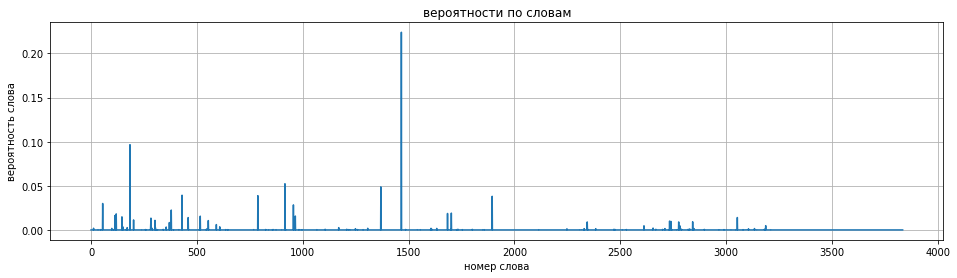

In [21]:
plt.figure(figsize=(16,4))
plt.plot(y_p[0,:])
plt.xlabel('номер слова')
plt.ylabel('вероятность слова')
plt.title('вероятности по словам')
plt.grid('on')
plt.show()

In [22]:
ind_prob=np.where(y_p[0,:]>0.0410)[0]
ind_prob

array([ 184,  916, 1369, 1466])

In [23]:
for i,ind in enumerate(ind_prob.tolist()):
  print(tokenizer.index_word[ind], ' : ', y_p[0,ind])

«0»  :  0.096599564
блокировкой  :  0.052315116
доступ  :  0.048804503
замыкания  :  0.22407739


# Вывод
модель стала лучше предсказывать следующее слово после обработки текста, удаления ненужных символов, знаков препинания, увеличение кол-ва слоев результата не дало, только обучаться сильно дольше стала модель, точность стала выше после увеличения эпох и кол-во нейронов